In [20]:
import pandas as pd
import numpy as np
from itertools import combinations_with_replacement, product

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import spatial

### Table with calculated mutspec for species in CytB

In [21]:
mut = pd.read_csv('../data/MutSpecVertebratescytb.csv')
mut.head()

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context,Class
0,Abbottina_obtusirostris,T[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,TTT,Actinopterygii
1,Abbottina_obtusirostris,G[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,GTT,Actinopterygii
2,Abbottina_obtusirostris,C[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,CTT,Actinopterygii
3,Abbottina_obtusirostris,A[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,ATT,Actinopterygii
4,Abbottina_obtusirostris,T[T>C]T,8.0,0.0,0.0,1.088889,0.0,T>C,TTT,Actinopterygii


### Cancer df obtained from cancer 
Each raw represents bootstraped mutspec of cancer, only syn mutations


In [46]:
canc_df = pd.read_csv('../data/human_cancer_spectra_syn_samples.csv')
canc_df = canc_df.reset_index().melt(id_vars=['index'], value_vars=canc_df.columns[0:])
canc_df = canc_df.rename(columns={'index': 'Species', 'variable': 'Mut', 'value': 'MutSpec'})
canc_df['Class'] = 'Cancer'
canc_df['MutBase'] = canc_df['Mut'].str.get(2) + '>' + canc_df['Mut'].str.get(4)
canc_df.head()

,Species,Mut,MutSpec,Class,MutBase
0,0,A[A>C]A,0.0,Cancer,A>C
1,1,A[A>C]A,0.0,Cancer,A>C
2,2,A[A>C]A,0.0,Cancer,A>C
3,3,A[A>C]A,0.0,Cancer,A>C
4,4,A[A>C]A,0.0,Cancer,A>C


### Create vectors of orderds in heatmap and combinations

In [64]:
cl_vec = list(mut['Class'].drop_duplicates()) + ['Cancer']
correct_order = ["Actinopterygii","Amphibia", "Lepidosauria", "Mammalia", "Aves", "Cancer"]

### Function to calculate mutspec for class
New approach: just mean without any ...

In [65]:
def calc_mutspec_class(df: pd.DataFrame):
    ms_cls = df.groupby(['Class','Mut'])['MutSpec'].mean().reset_index()
    return ms_cls

In [66]:
####
# This is the old one normalization process that we turned down
####def calc_mutspec_class(df: pd.DataFrame):
    #ms_cls = df.groupby(['Class','Mut'])['RawMutSpec'].sum().reset_index()
    #ms_cls["RawMutSpecSum"] = ms_cls.Class.map(ms_cls.groupby("Class").RawMutSpec.sum().to_dict())
    #ms_cls['MutSpec'] = ms_cls.RawMutSpec / ms_cls.RawMutSpecSum
    #ms_cls = ms_cls.drop(['RawMutSpec', 'RawMutSpecSum'], axis=1)
    #
    #return ms_cls

## Similarity JackKnife

Here is a function Jackknife for cosine similarity analysis. Every time we take randomly 20 species from each class and than calculate mutpsec for each class presented by those 20 species. Next do cosine similarity analysis.

In [67]:
TS_vec = ['A>G', 'G>A', 'T>C', 'C>T']
TV_vec = ['A>T', 'T>A', 'C>G', 'G>C', 'C>A', 'A>C', 'T>G', 'G>T']

def get_similarity_table(mut_df: pd.DataFrame, canc_df: pd.DataFrame, mut_type='all', n_iter=100):

    correct_order = ["Actinopterygii","Amphibia", "Lepidosauria", "Mammalia", "Aves", "Cancer"]

    to_heatmap = []

    if mut_type == 'TS':
        mut_to_cos = mut_df[mut_df['MutBase'].isin(TS_vec)]
        canc_df = canc_df[canc_df['MutBase'].isin(TS_vec)]
    elif mut_type == 'TV':
        mut_to_cos = mut_df[mut_df['MutBase'].isin(TV_vec)]
        canc_df = canc_df[canc_df['MutBase'].isin(TV_vec)]
    elif mut_type =='all':
        mut_to_cos = mut_df.copy()
    else:
        raise('Error, try another MutType')
    
    possible_comp = list(combinations_with_replacement(correct_order, 2))

    for comp in possible_comp:
       
        cls1 = comp[0]
        cls2 = comp[1]
        n = 0

        while n < n_iter:

            if cls1 != 'Cancer':
                
                df1_sps = mut_to_cos[mut_to_cos['Class'] == cls1]['Species'].sample(n=20, replace=False)
                df1 = calc_mutspec_class(mut_to_cos[mut_to_cos['Species'].isin(df1_sps)])
            else:

                df1_sps = canc_df['Species'].sample(n=20, replace=False)
                df1 = calc_mutspec_class(canc_df[canc_df['Species'].isin(df1_sps)])

            if cls2 != 'Cancer':
                df2_sps = mut_to_cos[mut_to_cos['Class'] == cls2]['Species'].sample(n=20, replace=False)
                df2 = calc_mutspec_class(mut_to_cos[mut_to_cos['Species'].isin(df2_sps)])
                cos192 = spatial.distance.cosine(df1['MutSpec'], df2['MutSpec'])

            else:
                df2_sps = canc_df['Species'].sample(n=20, replace=False)
                df2 = calc_mutspec_class(canc_df[canc_df['Species'].isin(df2_sps)])
                cos192 = spatial.distance.cosine(df1['MutSpec'], df2['MutSpec'])
                
            cos_res = {'Class1':cls1, 'Class2':cls2, 'Similarity':1-cos192}
            to_heatmap.append(cos_res)

            n += 1
    
    # ! in comm as we want to draw only half
    ### make a mirror form copied df for hetmap input
    #to_heatmap = pd.DataFrame(to_heatmap)
    #heatmap_copied = to_heatmap.copy().rename(columns={'Class1': 'Class2', 'Class2': 'Class1'})
    #res_fnl = pd.concat([to_heatmap, heatmap_copied]).drop_duplicates(['Class1', 'Class2', 'Similarity'])

    return pd.DataFrame(to_heatmap)

### Function to get Quantiles for each comparison btw classes

In [68]:
def get_quantiles_annot(heatmap_table: pd.DataFrame):
    
    correct_order = ["Actinopterygii", "Amphibia", "Lepidosauria", "Mammalia", "Aves", "Cancer"]  # make order of out df

    # Calculate quantiles for each combination of classes
    heatmap_table = heatmap_table.groupby(['Class1', 'Class2']).quantile([.25,.5,.75]).reset_index()
    heatmap_table['Similarity'] = heatmap_table['Similarity'].round(2)

    
    # Transform results to 2D array for annotating heatmap 
    out_quantile_annot = pd.DataFrame(np.nan, index= correct_order, columns = correct_order)
    
    for row_comb in range(0,len(heatmap_table),3):
        res_txt = []
        sampl = heatmap_table.iloc[row_comb:row_comb+3,:]
        cls1 = sampl.iloc[0,0]
        cls2 = sampl.iloc[0,1]
        res_txt.append(str(sampl.iloc[0,3]) + '\n' + str(sampl.iloc[1,3]) + '\n' + str(sampl.iloc[2,3]))
    
        out_quantile_annot[cls1][cls2] = ''.join(res_txt)

    return out_quantile_annot

### Function to draw Heatmap

In [84]:
def heatmap_similaruty(inp_heatmap: pd.DataFrame, save_path='', title='Similarity of mutational spectrum', col_ht='white'):
    
    # Calculate quantiles for annot
    quantiles_annot = get_quantiles_annot(inp_heatmap)

    # reshape input data tot heatmap format
    #inp_heatmap.loc[inp_heatmap['Class1'] == inp_heatmap['Class2'], 'Similarity'] = np.nan
    all_heatmap = inp_heatmap.groupby(['Class1', 'Class2']).median().reset_index().pivot('Class2', 'Class1', 'Similarity') 
    all_heatmap.index = pd.CategoricalIndex(all_heatmap.index, categories=correct_order)
    all_heatmap.sort_index(axis=0, inplace=True)
    all_heatmap = all_heatmap.reindex(correct_order, axis=1)

    # Plot heatmap
    plt.figure(figsize=(12, 12))
    ax = sns.heatmap(all_heatmap, cmap="crest", vmin=0.2, vmax=1, annot=quantiles_annot, annot_kws={"size": 11, 'color': col_ht}, fmt='')
    ax.tick_params(left=False, bottom=False)
    ax.set_title(title)
    
    if save_path != '':
        plt.savefig(save_path, dpi=400)

### JackKnife for all mutations

/var/folders/zp/hykk29rd2lndslkkjgkzfb640000gn/T/ipykernel_12621/3636509259.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_quantile_annot[cls1][cls2] = ''.join(res_txt)


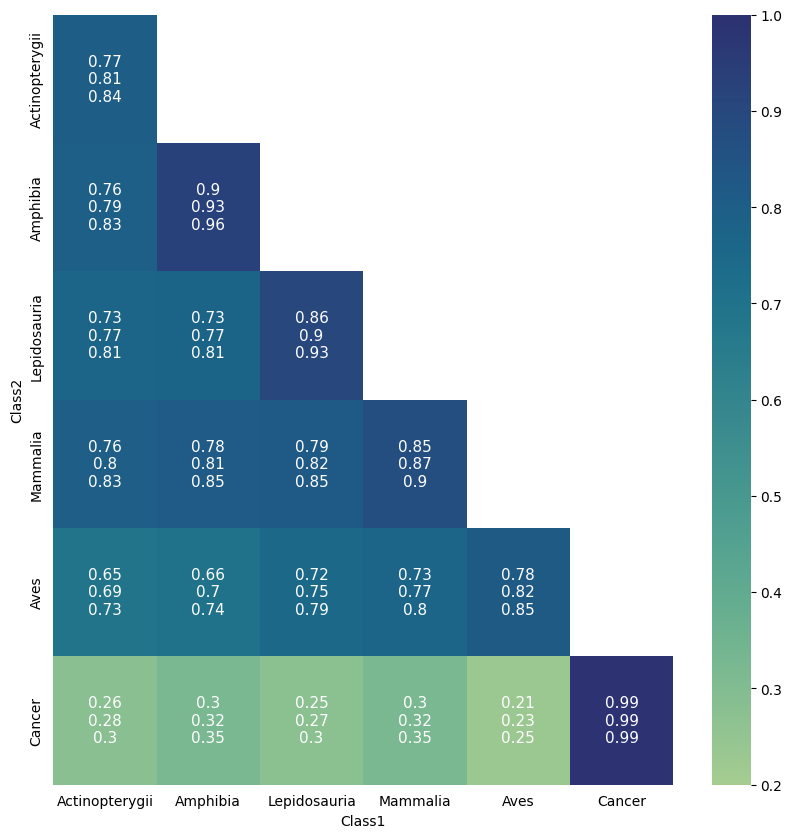

In [81]:
to_heatmap = get_similarity_table(mut_df=mut, canc_df=canc_df, mut_type='all', n_iter=1000)
heatmap_similaruty(to_heatmap, title='')

### JackKnife for transitions only

/var/folders/zp/hykk29rd2lndslkkjgkzfb640000gn/T/ipykernel_12930/3840433158.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_quantile_annot[cls1][cls2] = ''.join(res_txt)


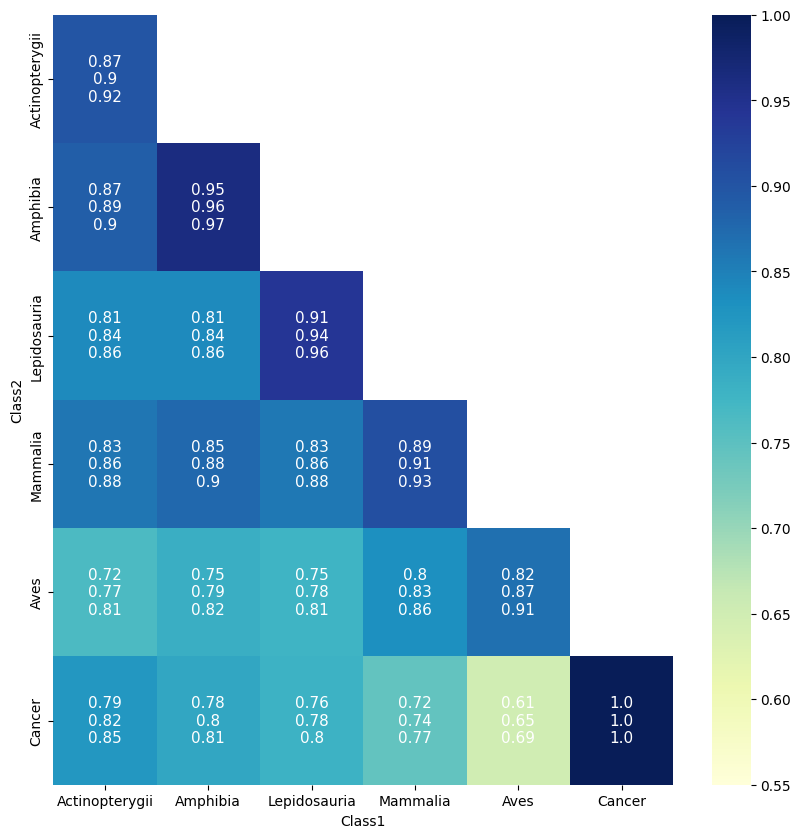

In [32]:
to_heatmap = get_similarity_table(mut_df=mut, canc_df=canc_df, mut_type='TS', n_iter=1000)
heatmap_similaruty(to_heatmap, save_path= '../pictures/HeatmapJack/Jackknife_SimilarityTS.pdf', title = '')

### JackKnife for transversions only

/var/folders/zp/hykk29rd2lndslkkjgkzfb640000gn/T/ipykernel_12930/3840433158.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_quantile_annot[cls1][cls2] = ''.join(res_txt)


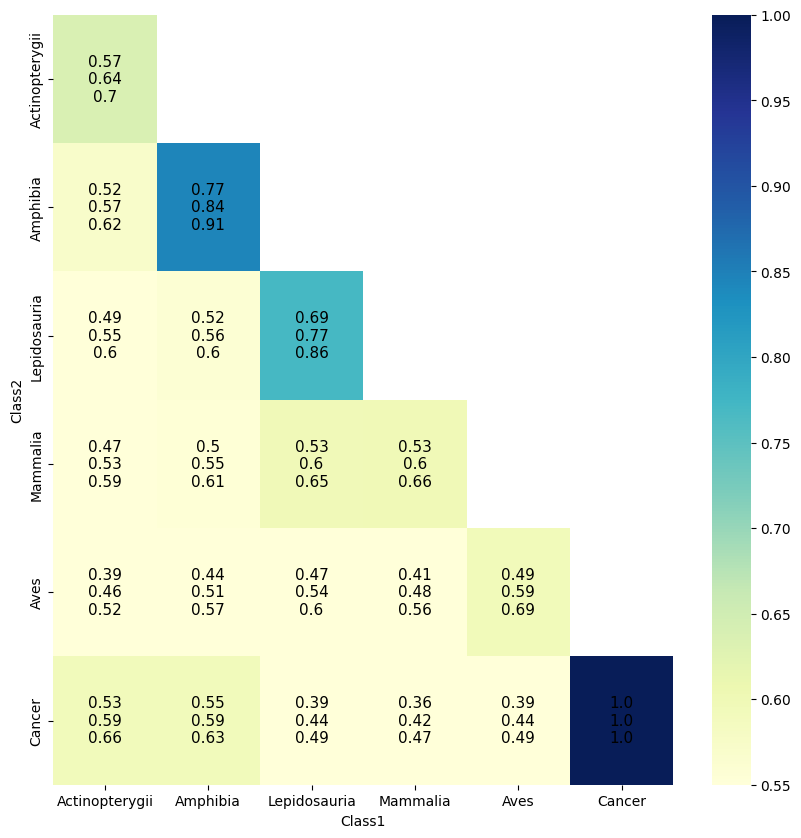

In [33]:
to_heatmap = get_similarity_table(mut_df=mut, canc_df=canc_df, mut_type='TV', n_iter=1000)
heatmap_similaruty(to_heatmap, save_path='../pictures/HeatmapJack/Jackknife_SimilarityTV.pdf', title='', col_ht='black')

### Jackknife for 4 types of substituion in transitions only!

/var/folders/zp/hykk29rd2lndslkkjgkzfb640000gn/T/ipykernel_12930/3840433158.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_quantile_annot[cls1][cls2] = ''.join(res_txt)
/var/folders/zp/hykk29rd2lndslkkjgkzfb640000gn/T/ipykernel_12930/3840433158.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_quantile_annot[cls1][cls2] = ''.join(res_txt)
/var/folders/zp/hykk29rd2lndslkkjgkzfb640000gn/T/ipykernel_12930/3840433158.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

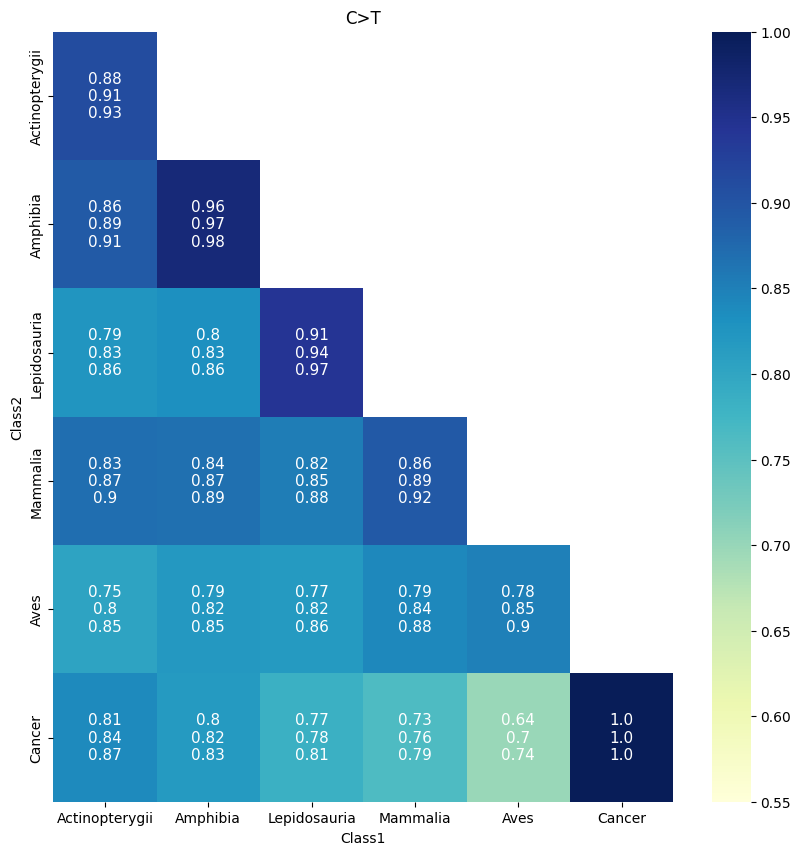

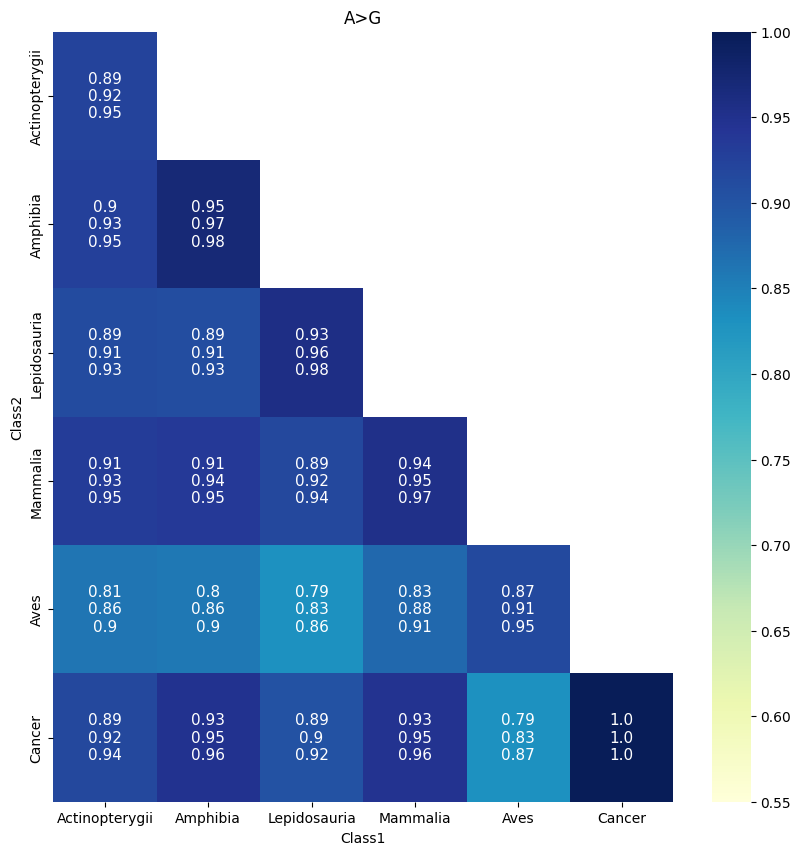

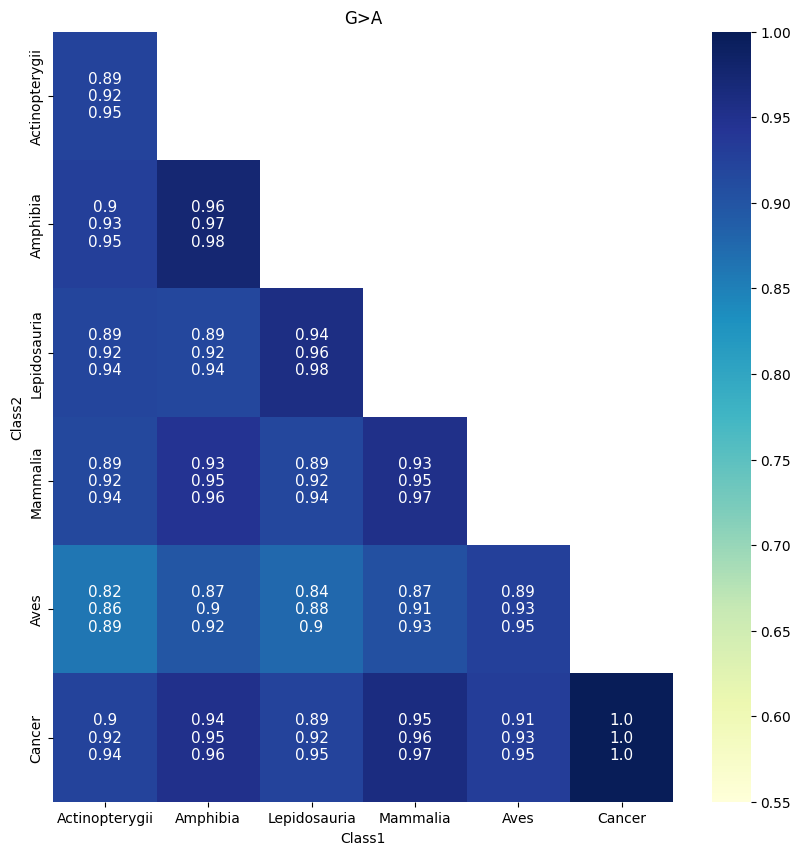

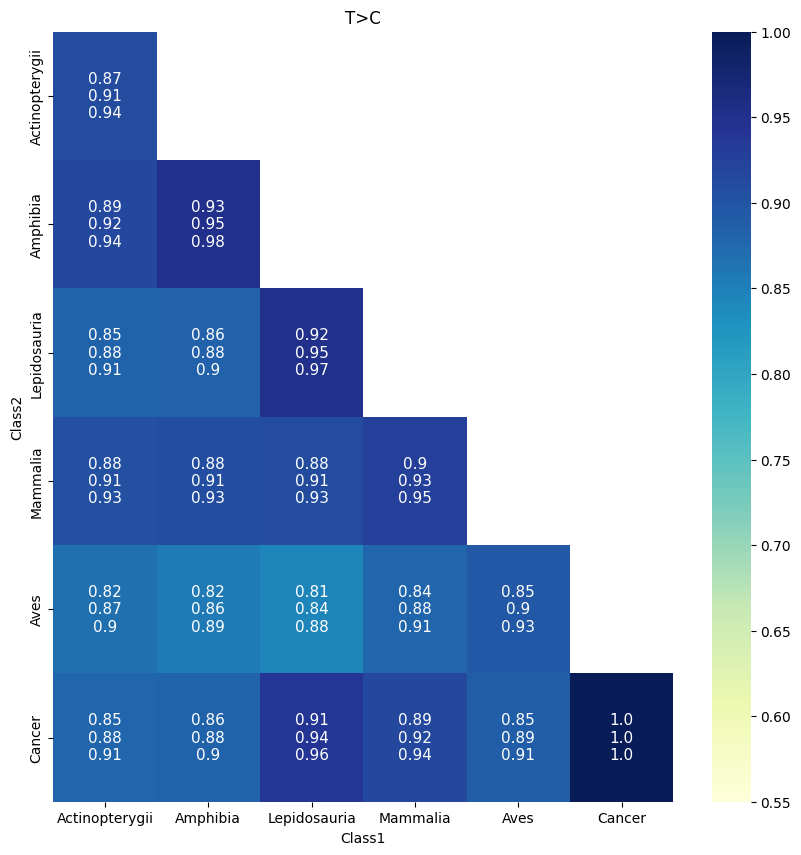

In [34]:
vec_of_subs_het = ['C>T', 'A>G', 'G>A', 'T>C']
TS_cancer = canc_df[canc_df['MutBase'].isin(TS_vec)]
TS_df = mut[mut['MutBase'].isin(TS_vec)]
for sub in vec_of_subs_het:
    needed_subs_df = TS_df[TS_df['MutBase'] == sub]
    cancer_needed_subs = TS_cancer[TS_cancer['MutBase'] == sub]
    to_heatmap = get_similarity_table(mut_df=needed_subs_df, canc_df=cancer_needed_subs, mut_type='all', n_iter=1000)
    heatmap_similaruty(to_heatmap, save_path=f'../pictures/HeatmapJack/Jackknife_Similarity{sub}.pdf', title=sub)